In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [2]:
sp500 = pd.read_csv('../data/sp500_stock_prices_2000_2025.csv', parse_dates=['Date'], skiprows=[1]).drop(columns=['Adj Close', 'Volume'])
sp500.set_index('Date', inplace=True)
ibm = pd.read_csv('../data/ibm_stock_prices_2000_2025.csv', parse_dates=['Date'], skiprows=[1]).drop(columns=['Adj Close', 'Volume'])
ibm.set_index('Date', inplace=True)

In [3]:
def create_sequence(data: pd.DataFrame, seq_length: int):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i + seq_length, :])
        y.append(data.iloc[i + seq_length, 3])
    return np.array(X), np.array(y)

#define model

In [ ]:
class GRUmodel(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super(GRUmodel, self).__init__()
    self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
    self.fc = nn.Linear(hidden_size, output_size)
  def forward(self, x):
    out, _ = self.gru(x)
    out = self.fc(out[:, -1, :])
    return out

In [ ]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs=10, batch_size=30):
  model.train()
  for epoch in range(epochs):
    for i in range(0, len(x_train), batch_size):
      x_batch = x_train[i:i+batch_size]
      y_batch = y_train[i:i+batch_size]
      optimizer.zero_grad()
      loss = criterion(model(x_batch),y_batch)
      loss.backward()
      optimizer.step()
  print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

In [ ]:
def evaluate_model(neurons, opt, x_train, y_train, x_test, y_test, epochs=10, batch_size=30):
  model = GRUmodel(input_size = 4, hidden_size= neurons, output_size=1)
  criterion = nn.MSELoss()
  if opt == 'adam':
    optimizer = torch.optim.Adam(model.parameters(), lr = 0.01)
  else:
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

  train_model(model, criterion, optimizer, x_train, y_train, epochs=epochs, batch_size=batch_size)
  model.eval()
  with torch.no_grad():
    y_pred = model(x_test)
  mse = criterion(y_test, y_pred)
  return mse, model

In [ ]:
# Real
seq_lengths = [15, 20, 30, 50]
# Test
# seq_lengths = [15]
logger = []
num_features = 4
for ticker, df in zip(['SP500', 'IBM'], [sp500.copy(), ibm.copy()]):
    for seq_length in seq_lengths:
        X,y = create_sequence(df, seq_length)
        train_size = int(len(df)*0.8)
        X_train, X_test = X[0:train_size, :], X[train_size:, :]
        y_train, y_test = y[0:train_size], y[train_size:]
        scalerX = MinMaxScaler(feature_range =(0,1))
        scalery = MinMaxScaler(feature_range = (0,1))

        x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
        x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
        y_train = scalery.fit_transform(y_train.reshape(-1,1))
        y_test = scalery.transform(y_test.reshape(-1,1))
        x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
        x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
        y_train = torch.from_numpy(y_train).float()
        y_test = torch.from_numpy(y_test).float()
        print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
        best_mse = float('inf')
        best_params = {}
        # Real
        neurons = [200,500,800, 1000]
        # Test
        # neurons = [50]
        optimizers = ['adam', 'sgd']

        for n in neurons:
            for opt in optimizers:
                mse, model = evaluate_model(n, opt, x_train, y_train, x_test, y_test)
                print(f'Ticker: {ticker}, Length: {seq_length}, Neurons: {n}, Optimizer: {opt}, MSE: {mse}')
                logger.append({
                    'seq_length': seq_length,
                    'neurons': n,
                    'optimizer': opt,
                    'mse': mse.item(),
                    'ticker': ticker,
                    'model_state_dict': model.state_dict()
                })

torch.Size([5095, 15, 4]) torch.Size([1259, 15, 4]) torch.Size([5095, 1]) torch.Size([1259, 1])
Epoch [10/10], Loss: 0.0789
Ticker: SP500, Length: 15, Neurons: 200, Optimizer: adam, MSE: 0.25823119282722473
Epoch [10/10], Loss: 0.0009
Ticker: SP500, Length: 15, Neurons: 200, Optimizer: sgd, MSE: 0.04668029397726059
Epoch [10/10], Loss: 0.0243
Ticker: SP500, Length: 15, Neurons: 500, Optimizer: adam, MSE: 1.0380804538726807
Epoch [10/10], Loss: 0.0008
Ticker: SP500, Length: 15, Neurons: 500, Optimizer: sgd, MSE: 0.030318383127450943
Epoch [10/10], Loss: 0.0159
Ticker: SP500, Length: 15, Neurons: 800, Optimizer: adam, MSE: 0.7808650135993958
Epoch [10/10], Loss: 0.0008
Ticker: SP500, Length: 15, Neurons: 800, Optimizer: sgd, MSE: 0.02479073591530323
Epoch [10/10], Loss: 0.0978
Ticker: SP500, Length: 15, Neurons: 1000, Optimizer: adam, MSE: 0.37305065989494324
Epoch [10/10], Loss: 0.0008
Ticker: SP500, Length: 15, Neurons: 1000, Optimizer: sgd, MSE: 0.02790147066116333
torch.Size([5095, 2

In [22]:
sp500_logger = [log for log in logger if log['Ticker'] == 'SP500']
ibm_logger = [log for log in logger if log['Ticker'] == 'IBM']

In [24]:
sp500_logger_sorted = sorted(sp500_logger, key=lambda x: x['mse'])
ibm_logger_sorted = sorted(ibm_logger, key=lambda x: x['mse'])

In [27]:
best_config_sp500 = sp500_logger_sorted[0]
best_config_ibm = ibm_logger_sorted[0]

In [28]:
best_config_sp500

{'seq_length': 50,
 'neurons': 800,
 'optimizer': 'sgd',
 'mse': 0.02447357401251793,
 'Ticker': 'SP500'}

In [32]:
best_config_ibm

{'seq_length': 30,
 'neurons': 200,
 'optimizer': 'adam',
 'mse': 0.0018406125018373132,
 'Ticker': 'IBM'}

In [33]:
def run_model(config):
    if config['Ticker'] == 'SP500':
        X, y = create_sequence(sp500, config['seq_length'])
    else:
        X,y = create_sequence(ibm, config['seq_length'])
    seq_length = config['seq_length']
    train_size = int(len(df)*0.8)
    X_train, X_test = X[0:train_size, :], X[train_size:, :]
    y_train, y_test = y[0:train_size], y[train_size:]
    scalerX = MinMaxScaler(feature_range =(0,1))
    scalery = MinMaxScaler(feature_range = (0,1))

    x_train = scalerX.fit_transform(X_train.reshape(-1, num_features*seq_length))
    x_test = scalerX.transform(X_test.reshape(-1, num_features*seq_length))
    y_train = scalery.fit_transform(y_train.reshape(-1,1))
    y_test = scalery.transform(y_test.reshape(-1,1))
    x_train = torch.from_numpy(x_train.reshape(-1, seq_length, num_features)).float()
    x_test = torch.from_numpy(x_test.reshape(-1, seq_length, num_features)).float()
    y_train = torch.from_numpy(y_train).float()
    y_test = torch.from_numpy(y_test).float()

    mse,model = evaluate_model(
        config['neurons'], config['optimizer'], x_train, y_train, x_test, y_test, epochs=10, batch_size=30
    )

    model.eval()
    with torch.no_grad():
        y_pred = model(x_test)
    
    y_pred = scalery.inverse_transform(y_pred.numpy())
    y_test = scalery.inverse_transform(y_test.numpy())
    return y_pred, y_test, mse.item(), model

In [ ]:
y_pred_sp500, y_test_sp500, mse_sp500, model_sp500 = run_model(best_config_sp500)
y_pred_ibm, y_test_ibm, mse_ibm, model_ibm = run_model(best_config_ibm)

Epoch [10/10], Loss: 0.0015


ValueError: cannot reshape array of size 149280 into shape (200)

Epoch [10/10], Loss: 0.0011


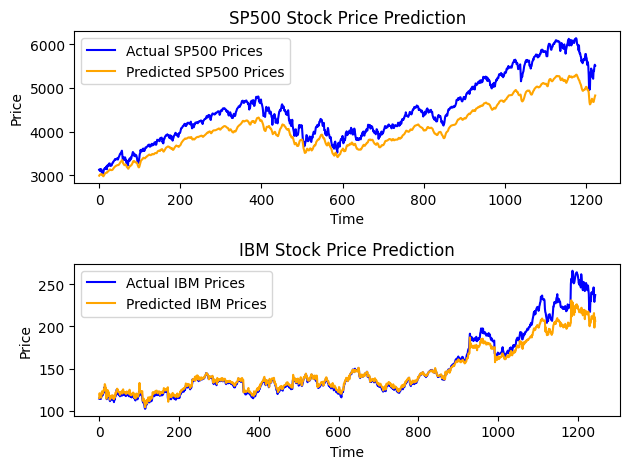

In [39]:
# Sketch the results
# plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(y_test_sp500, label='Actual SP500 Prices', color='blue')
plt.plot(y_pred_sp500, label='Predicted SP500 Prices', color='orange')
plt.title('SP500 Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.subplot(2, 1, 2)
plt.plot(y_test_ibm, label='Actual IBM Prices', color='blue')
plt.plot(y_pred_ibm, label='Predicted IBM Prices', color='orange')
plt.title('IBM Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.tight_layout()
# plt.savefig('stock_price_prediction.png')
plt.show()

In [40]:
from sklearn.metrics import mean_absolute_error


def evaluate_model(y_actual, y_pred,model_name='Model'):
    mse = mean_squared_error(y_actual, y_pred)
    mae = mean_absolute_error(y_actual, y_pred)
    mape = np.mean(np.abs((y_actual - y_pred) / y_actual)) * 100
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, MAPE: {mape:.2f}%")

In [41]:
for ticker, y_test, y_pred in zip(['SP500', 'IBM'], [y_test_sp500, y_test_ibm], [y_pred_sp500, y_pred_ibm]):
    evaluate_model(y_test, y_pred, model_name=f"{ticker} LSTM Model")

SP500 LSTM Model - MSE: 193953.0469, MAE: 399.5040, MAPE: 8.52%
IBM LSTM Model - MSE: 103.7740, MAE: 5.7999, MAPE: 3.12%
